# Interactions and ANOVA

Note: This script is based heavily on Jonathan Taylor's class notes https://web.stanford.edu/class/stats191/notebooks/Interactions.html

Download and format data:

In [1]:
%matplotlib inline

In [2]:
import os
import shutil

import numpy as np
import requests

np.set_printoptions(precision=4, suppress=True)

import pandas as pd

pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import abline_plot, interaction_plot
from statsmodels.stats.anova import anova_lm


def download_file(url, mode="t"):
    local_filename = url.split("/")[-1]
    if os.path.exists(local_filename):
        return local_filename
    with requests.get(url, stream=True) as r:
        with open(local_filename, f"w{mode}") as f:
            f.write(r.text)
    return local_filename


url = "https://raw.githubusercontent.com/statsmodels/smdatasets/main/data/anova/salary/salary.table"
salary_table = pd.read_csv(download_file(url), sep="\t")

E = salary_table.E
M = salary_table.M
X = salary_table.X
S = salary_table.S

Take a look at the data:

Text(0, 0.5, 'Salary')

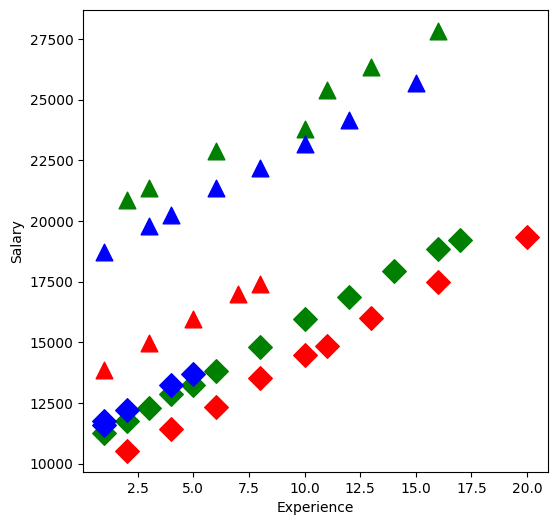

In [3]:
plt.figure(figsize=(6, 6))
symbols = ["D", "^"]
colors = ["r", "g", "blue"]
factor_groups = salary_table.groupby(["E", "M"])
for values, group in factor_groups:
    i, j = values
    plt.scatter(group["X"], group["S"], marker=symbols[j], color=colors[i - 1], s=144)
plt.xlabel("Experience")
plt.ylabel("Salary")

Fit a linear model:

In [4]:
formula = "S ~ C(E) + C(M) + X"
lm = ols(formula, salary_table).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           2.23e-27
Time:                        13:04:05   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.0

Have a look at the created design matrix: 

In [5]:
lm.model.exog[:5]

array([[1., 0., 0., 1., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1.]])

Or since we initially passed in a DataFrame, we have a DataFrame available in

In [6]:
lm.model.data.orig_exog[:5]

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],X
0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0


We keep a reference to the original untouched data in

In [7]:
lm.model.data.frame[:5]

,S,X,E,M
0,13876,1,1,1
1,11608,1,3,0
2,18701,1,3,1
3,11283,1,2,0
4,11767,1,3,0


Influence statistics

In [8]:
infl = lm.get_influence()
print(infl.summary_table())

       obs      endog     fitted     Cook's   student.   hat diag    dffits   ext.stud.     dffits
                           value          d   residual              internal   residual           
--------------------------------------------------------------------------------------------------
         0  13876.000  15465.313      0.104     -1.683      0.155     -0.722     -1.723     -0.739
         1  11608.000  11577.992      0.000      0.031      0.130      0.012      0.031      0.012
         2  18701.000  18461.523      0.001      0.247      0.109      0.086      0.244      0.085
         3  11283.000  11725.817      0.005     -0.458      0.113     -0.163     -0.453     -0.162
         4  11767.000  11577.992      0.001      0.197      0.130      0.076      0.195      0.075
         5  20872.000  19155.532      0.092      1.787      0.126      0.678      1.838      0.698
         6  11772.000  12272.001      0.006     -0.513      0.101     -0.172     -0.509     -0.170
         7

or get a dataframe

In [9]:
df_infl = infl.summary_frame()

In [10]:
df_infl[:5]

,dfb_Intercept,dfb_C(E)[T.2],dfb_C(E)[T.3],dfb_C(M)[T.1],dfb_X,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.505123,0.376134,0.483977,-0.369677,0.399111,0.104186,-1.683099,0.155327,-0.721753,-1.723037,-0.738880
1,0.004663,0.000145,0.006733,-0.006220,-0.004449,0.000029,0.031318,0.130266,0.012120,0.030934,0.011972
2,0.013627,0.000367,0.036876,0.030514,-0.034970,0.001492,0.246931,0.109021,0.086377,0.244082,0.085380
3,-0.083152,-0.074411,0.009704,0.053783,0.105122,0.005338,-0.457630,0.113030,-0.163364,-0.453173,-0.161773
4,0.029382,0.000917,0.042425,-0.039198,-0.028036,0.001166,0.197257,0.130266,0.076340,0.194929,0.075439


Now plot the residuals within the groups separately:

Text(0, 0.5, 'Residuals')

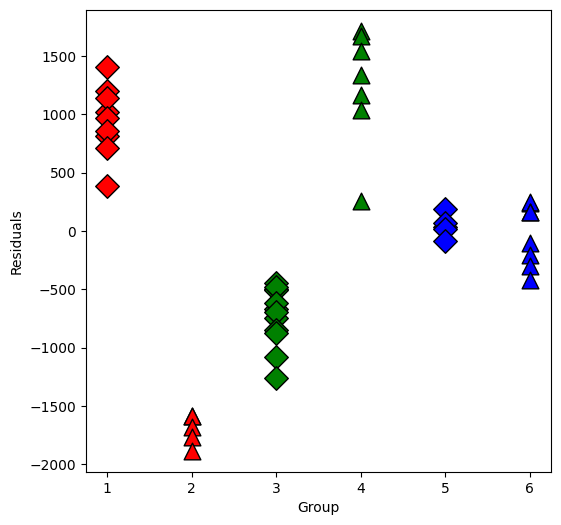

In [11]:
resid = lm.resid
plt.figure(figsize=(6, 6))
for values, group in factor_groups:
    i, j = values
    group_num = i * 2 + j - 1  # for plotting purposes
    x = [group_num] * len(group)
    plt.scatter(
        x,
        resid[group.index],
        marker=symbols[j],
        color=colors[i - 1],
        s=144,
        edgecolors="black",
    )
plt.xlabel("Group")
plt.ylabel("Residuals")

Now we will test some interactions using anova or f_test

In [12]:
interX_lm = ols("S ~ C(E) * X + C(M)", salary_table).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           8.23e-26
Time:                        13:04:05   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      

Do an ANOVA check

In [13]:
from statsmodels.stats.api import anova_lm

table1 = anova_lm(lm, interX_lm)
print(table1)

interM_lm = ols("S ~ X + C(E)*C(M)", data=salary_table).fit()
print(interM_lm.summary())

table2 = anova_lm(lm, interM_lm)
print(table2)

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      41.0  4.328072e+07      0.0           NaN       NaN       NaN
1      39.0  3.941068e+07      2.0  3.870040e+06  1.914856  0.160964
                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           1.67e-55
Time:                        13:04:05   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
   

The design matrix as a DataFrame

In [14]:
interM_lm.model.data.orig_exog[:5]

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],C(E)[T.2]:C(M)[T.1],C(E)[T.3]:C(M)[T.1],X
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0


The design matrix as an ndarray

In [15]:
interM_lm.model.exog
interM_lm.model.exog_names

['Intercept',
 'C(E)[T.2]',
 'C(E)[T.3]',
 'C(M)[T.1]',
 'C(E)[T.2]:C(M)[T.1]',
 'C(E)[T.3]:C(M)[T.1]',
 'X']

Text(0, 0.5, 'standardized resids')

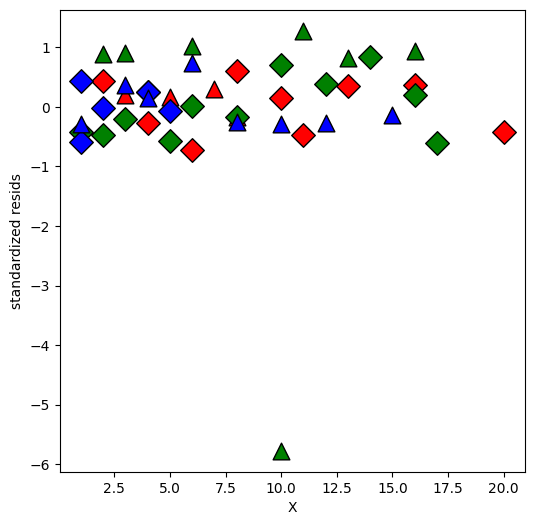

In [16]:
infl = interM_lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(6, 6))
for values, group in factor_groups:
    i, j = values
    idx = group.index
    plt.scatter(
        X[idx],
        resid[idx],
        marker=symbols[j],
        color=colors[i - 1],
        s=144,
        edgecolors="black",
    )
plt.xlabel("X")
plt.ylabel("standardized resids")

Looks like one observation is an outlier.

In [17]:
drop_idx = abs(resid).argmax()
print(drop_idx)  # zero-based index
idx = salary_table.index.drop(drop_idx)

lm32 = ols("S ~ C(E) + X + C(M)", data=salary_table, subset=idx).fit()

print(lm32.summary())
print("\n")

interX_lm32 = ols("S ~ C(E) * X + C(M)", data=salary_table, subset=idx).fit()

print(interX_lm32.summary())
print("\n")


table3 = anova_lm(lm32, interX_lm32)
print(table3)
print("\n")


interM_lm32 = ols("S ~ X + C(E) * C(M)", data=salary_table, subset=idx).fit()

table4 = anova_lm(lm32, interM_lm32)
print(table4)
print("\n")

32
                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     211.7
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           2.45e-26
Time:                        13:04:06   Log-Likelihood:                -373.79
No. Observations:                  45   AIC:                             757.6
Df Residuals:                      40   BIC:                             766.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8044.7518    392.781     20.482      

 Replot the residuals

Text(0, 0.5, 'standardized resids')

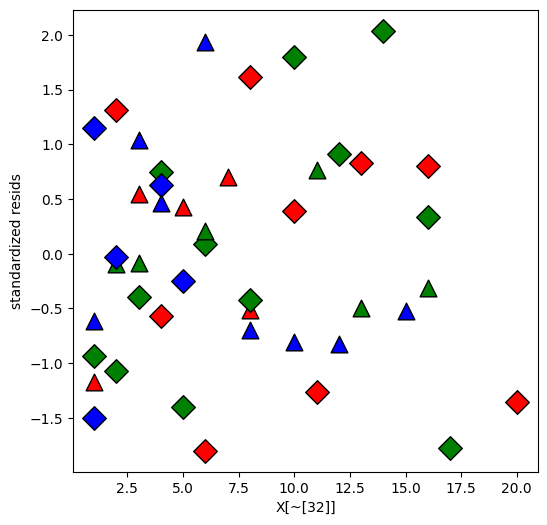

In [18]:
resid = interM_lm32.get_influence().summary_frame()["standard_resid"]

plt.figure(figsize=(6, 6))
resid = resid.reindex(X.index)
for values, group in factor_groups:
    i, j = values
    idx = group.index
    plt.scatter(
        X.loc[idx],
        resid.loc[idx],
        marker=symbols[j],
        color=colors[i - 1],
        s=144,
        edgecolors="black",
    )
plt.xlabel("X[~[32]]")
plt.ylabel("standardized resids")

 Plot the fitted values

Text(0, 0.5, 'Salary')

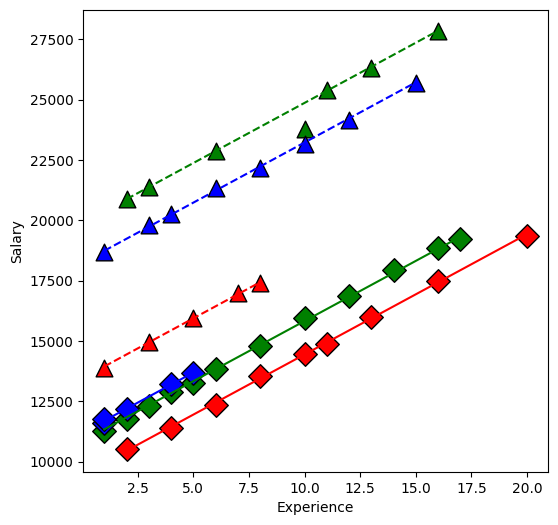

In [19]:
lm_final = ols("S ~ X + C(E)*C(M)", data=salary_table.drop([drop_idx])).fit()
mf = lm_final.model.data.orig_exog
lstyle = ["-", "--"]

plt.figure(figsize=(6, 6))
for values, group in factor_groups:
    i, j = values
    idx = group.index
    plt.scatter(
        X[idx],
        S[idx],
        marker=symbols[j],
        color=colors[i - 1],
        s=144,
        edgecolors="black",
    )
    # drop NA because there is no idx 32 in the final model
    fv = lm_final.fittedvalues.reindex(idx).dropna()
    x = mf.X.reindex(idx).dropna()
    plt.plot(x, fv, ls=lstyle[j], color=colors[i - 1])
plt.xlabel("Experience")
plt.ylabel("Salary")

From our first look at the data, the difference between Master's and PhD in the management group is different than in the non-management group. This is an interaction between the two qualitative variables management,M and education,E. We can visualize this by first removing the effect of experience, then plotting the means within each of the 6 groups using interaction.plot.

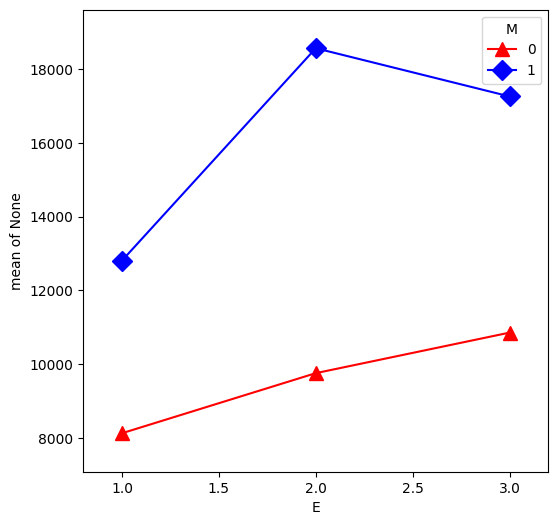

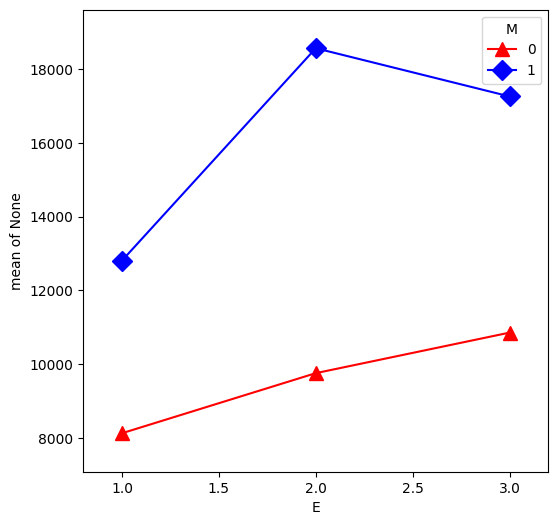

In [20]:
U = S - X * interX_lm32.params["X"]

plt.figure(figsize=(6, 6))
interaction_plot(
    E, M, U, colors=["red", "blue"], markers=["^", "D"], markersize=10, ax=plt.gca()
)

## Ethnic Employment Data

Text(0, 0.5, 'JPERF')

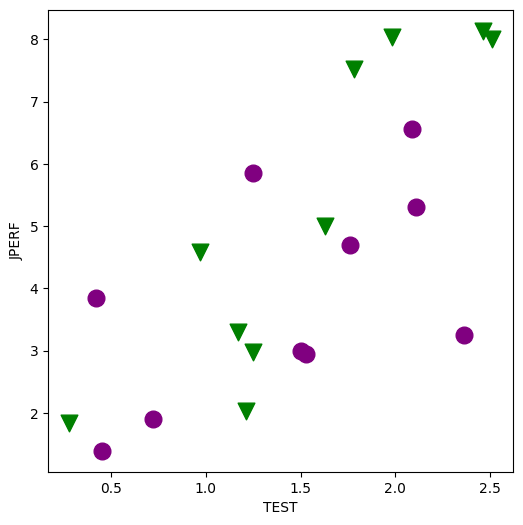

In [21]:
url = "https://raw.githubusercontent.com/statsmodels/smdatasets/main/data/anova/jobtest/jobtest.table"
jobtest_table = pd.read_csv(download_file(url), sep="\t")

factor_group = jobtest_table.groupby(["ETHN"])

fig, ax = plt.subplots(figsize=(6, 6))
colors = ["purple", "green"]
markers = ["o", "v"]
for factor, group in factor_group:
    factor_id = np.squeeze(factor)
    ax.scatter(
        group["TEST"],
        group["JPERF"],
        color=colors[factor_id],
        marker=markers[factor_id],
        s=12**2,
    )
ax.set_xlabel("TEST")
ax.set_ylabel("JPERF")

In [22]:
min_lm = ols("JPERF ~ TEST", data=jobtest_table).fit()
print(min_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     19.25
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           0.000356
Time:                        13:04:08   Log-Likelihood:                -36.614
No. Observations:                  20   AIC:                             77.23
Df Residuals:                      18   BIC:                             79.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0350      0.868      1.192      0.2

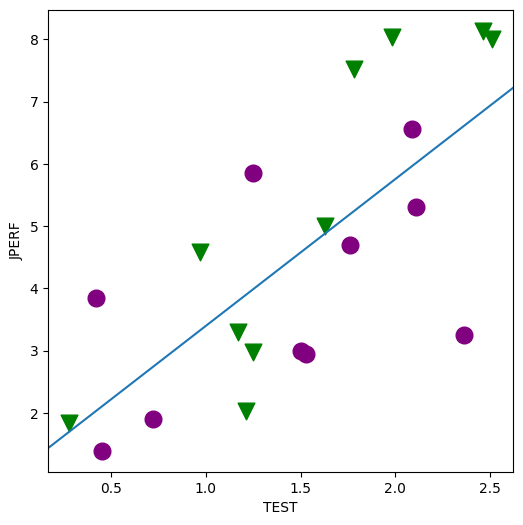

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
for factor, group in factor_group:
    factor_id = np.squeeze(factor)
    ax.scatter(
        group["TEST"],
        group["JPERF"],
        color=colors[factor_id],
        marker=markers[factor_id],
        s=12**2,
    )

ax.set_xlabel("TEST")
ax.set_ylabel("JPERF")
fig = abline_plot(model_results=min_lm, ax=ax)

In [24]:
min_lm2 = ols("JPERF ~ TEST + TEST:ETHN", data=jobtest_table).fit()

print(min_lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     14.59
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           0.000204
Time:                        13:04:09   Log-Likelihood:                -33.891
No. Observations:                  20   AIC:                             73.78
Df Residuals:                      17   BIC:                             76.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1211      0.780      1.437      0.1

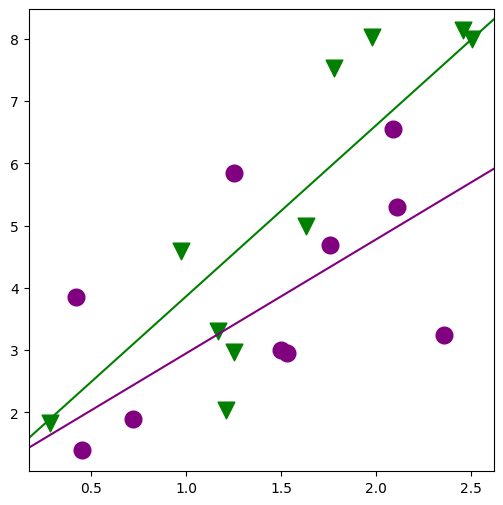

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
for factor, group in factor_group:
    factor_id = np.squeeze(factor)
    ax.scatter(
        group["TEST"],
        group["JPERF"],
        color=colors[factor_id],
        marker=markers[factor_id],
        s=12**2,
    )

fig = abline_plot(
    intercept=min_lm2.params["Intercept"],
    slope=min_lm2.params["TEST"],
    ax=ax,
    color="purple",
)
fig = abline_plot(
    intercept=min_lm2.params["Intercept"],
    slope=min_lm2.params["TEST"] + min_lm2.params["TEST:ETHN"],
    ax=ax,
    color="green",
)

In [26]:
min_lm3 = ols("JPERF ~ TEST + ETHN", data=jobtest_table).fit()
print(min_lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     11.38
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           0.000731
Time:                        13:04:10   Log-Likelihood:                -35.390
No. Observations:                  20   AIC:                             76.78
Df Residuals:                      17   BIC:                             79.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6120      0.887      0.690      0.5

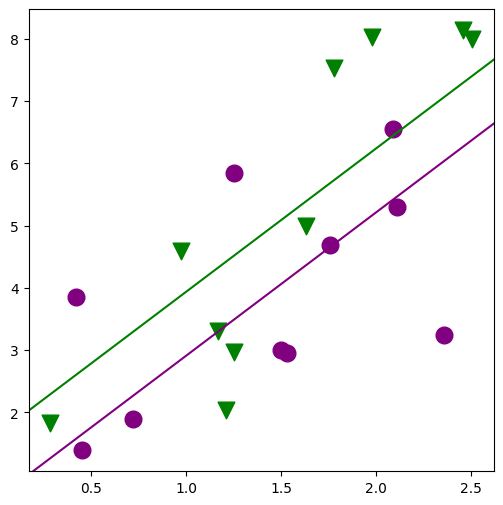

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
for factor, group in factor_group:
    factor_id = np.squeeze(factor)
    ax.scatter(
        group["TEST"],
        group["JPERF"],
        color=colors[factor_id],
        marker=markers[factor_id],
        s=12**2,
    )

fig = abline_plot(
    intercept=min_lm3.params["Intercept"],
    slope=min_lm3.params["TEST"],
    ax=ax,
    color="purple",
)
fig = abline_plot(
    intercept=min_lm3.params["Intercept"] + min_lm3.params["ETHN"],
    slope=min_lm3.params["TEST"],
    ax=ax,
    color="green",
)

In [28]:
min_lm4 = ols("JPERF ~ TEST * ETHN", data=jobtest_table).fit()
print(min_lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           0.000451
Time:                        13:04:10   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0103      1.050      1.914      0.0

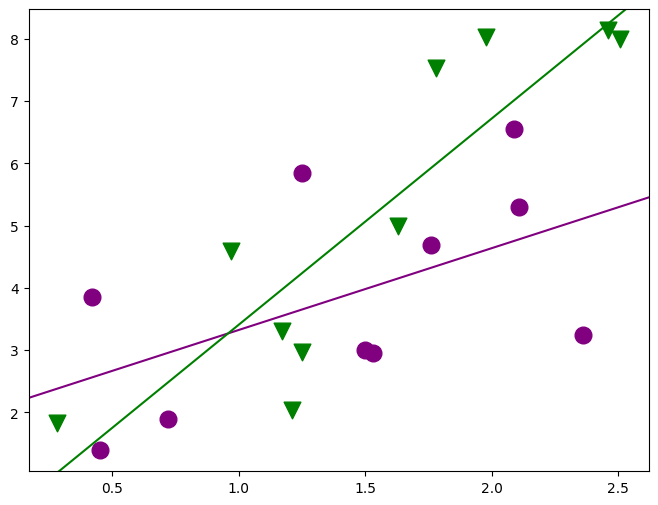

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
for factor, group in factor_group:
    factor_id = np.squeeze(factor)
    ax.scatter(
        group["TEST"],
        group["JPERF"],
        color=colors[factor_id],
        marker=markers[factor_id],
        s=12**2,
    )

fig = abline_plot(
    intercept=min_lm4.params["Intercept"],
    slope=min_lm4.params["TEST"],
    ax=ax,
    color="purple",
)
fig = abline_plot(
    intercept=min_lm4.params["Intercept"] + min_lm4.params["ETHN"],
    slope=min_lm4.params["TEST"] + min_lm4.params["TEST:ETHN"],
    ax=ax,
    color="green",
)

In [30]:
# is there any effect of ETHN on slope or intercept?
table5 = anova_lm(min_lm, min_lm4)
print(table5)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      16.0  31.655473      2.0  13.912824  3.516061  0.054236


In [31]:
# is there any effect of ETHN on intercept
table6 = anova_lm(min_lm, min_lm3)
print(table6)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0       NaN       NaN       NaN
1      17.0  40.321546      1.0  5.246751  2.212087  0.155246


In [32]:
# is there any effect of ETHN on slope
table7 = anova_lm(min_lm, min_lm2)
print(table7)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0      18.0  45.568297      0.0        NaN       NaN       NaN
1      17.0  34.707653      1.0  10.860644  5.319603  0.033949


In [33]:
# is it just the slope or both?
table8 = anova_lm(min_lm2, min_lm4)
print(table8)

   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0      17.0  34.707653      0.0      NaN       NaN       NaN
1      16.0  31.655473      1.0  3.05218  1.542699  0.232115


## One-way ANOVA

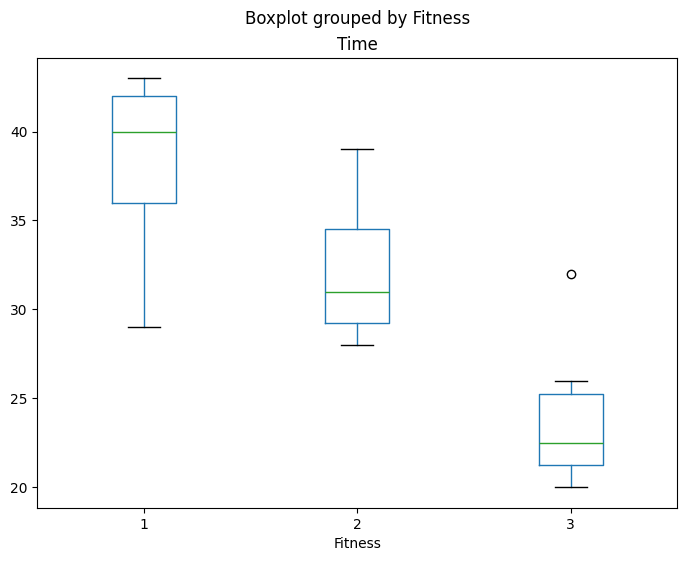

In [34]:
url = "https://raw.githubusercontent.com/statsmodels/smdatasets/main/data/anova/rehab/rehab.csv"
rehab_table = pd.read_csv(download_file(url))


fig, ax = plt.subplots(figsize=(8, 6))
fig = rehab_table.boxplot("Time", "Fitness", ax=ax, grid=False)

In [35]:
rehab_lm = ols("Time ~ C(Fitness)", data=rehab_table).fit()
table9 = anova_lm(rehab_lm)
print(table9)

print(rehab_lm.model.data.orig_exog)

              df  sum_sq     mean_sq          F    PR(>F)
C(Fitness)   2.0   672.0  336.000000  16.961538  0.000041
Residual    21.0   416.0   19.809524        NaN       NaN
    Intercept  C(Fitness)[T.2]  C(Fitness)[T.3]
0         1.0              0.0              0.0
1         1.0              0.0              0.0
2         1.0              0.0              0.0
3         1.0              0.0              0.0
4         1.0              0.0              0.0
5         1.0              0.0              0.0
6         1.0              0.0              0.0
7         1.0              0.0              0.0
8         1.0              1.0              0.0
9         1.0              1.0              0.0
10        1.0              1.0              0.0
11        1.0              1.0              0.0
12        1.0              1.0              0.0
13        1.0              1.0              0.0
14        1.0              1.0              0.0
15        1.0              1.0              0.0
16        

In [36]:
print(rehab_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     16.96
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           4.13e-05
Time:                        13:04:11   Log-Likelihood:                -68.286
No. Observations:                  24   AIC:                             142.6
Df Residuals:                      21   BIC:                             146.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          38.0000      1.574     

## Two-way ANOVA

In [37]:
url = "https://raw.githubusercontent.com/statsmodels/smdatasets/main/data/anova/kidney/kidney.table"
kidney_table = pd.read_csv(download_file(url), sep=r"\s+", engine="python")

Explore the dataset

In [38]:
kidney_table.head(10)

,Days,Duration,Weight,ID
0,0.0,1,1,1
1,2.0,1,1,2
2,1.0,1,1,3
3,3.0,1,1,4
4,0.0,1,1,5
5,2.0,1,1,6
6,0.0,1,1,7
7,5.0,1,1,8
8,6.0,1,1,9
9,8.0,1,1,10


Balanced panel

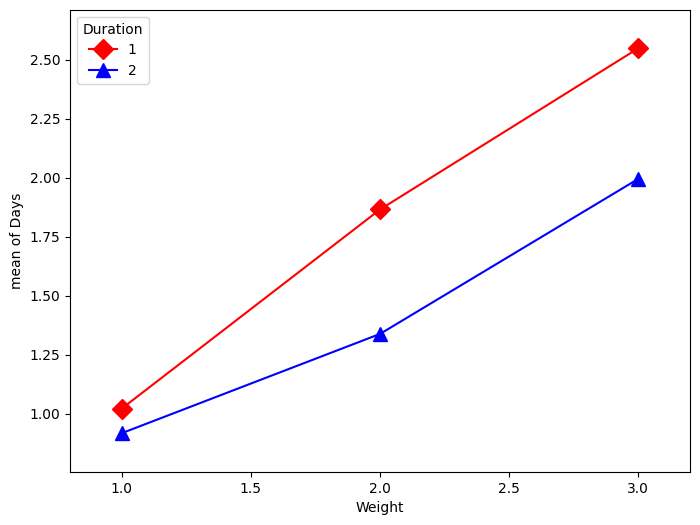

In [39]:
kt = kidney_table
plt.figure(figsize=(8, 6))
fig = interaction_plot(
    kt["Weight"],
    kt["Duration"],
    np.log(kt["Days"] + 1),
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=plt.gca(),
)

You have things available in the calling namespace available in the formula evaluation namespace

In [40]:
kidney_lm = ols("np.log(Days+1) ~ C(Duration) * C(Weight)", data=kt).fit()

table10 = anova_lm(kidney_lm)

print(
    anova_lm(ols("np.log(Days+1) ~ C(Duration) + C(Weight)", data=kt).fit(), kidney_lm)
)
print(
    anova_lm(
        ols("np.log(Days+1) ~ C(Duration)", data=kt).fit(),
        ols("np.log(Days+1) ~ C(Duration) + C(Weight, Sum)", data=kt).fit(),
    )
)
print(
    anova_lm(
        ols("np.log(Days+1) ~ C(Weight)", data=kt).fit(),
        ols("np.log(Days+1) ~ C(Duration) + C(Weight, Sum)", data=kt).fit(),
    )
)

   df_resid        ssr  df_diff   ss_diff        F    Pr(>F)
0      56.0  29.624856      0.0       NaN      NaN       NaN
1      54.0  28.989198      2.0  0.635658  0.59204  0.556748
   df_resid        ssr  df_diff    ss_diff          F    Pr(>F)
0      58.0  46.596147      0.0        NaN        NaN       NaN
1      56.0  29.624856      2.0  16.971291  16.040454  0.000003
   df_resid        ssr  df_diff   ss_diff         F   Pr(>F)
0      57.0  31.964549      0.0       NaN       NaN      NaN
1      56.0  29.624856      1.0  2.339693  4.422732  0.03997


## Sum of squares

 Illustrates the use of different types of sums of squares (I,II,II)
 and how the Sum contrast can be used to produce the same output between
 the 3.

 Types I and II are equivalent under a balanced design.

 Do not use Type III with non-orthogonal contrast - ie., Treatment

In [41]:
sum_lm = ols("np.log(Days+1) ~ C(Duration, Sum) * C(Weight, Sum)", data=kt).fit()

print(anova_lm(sum_lm))
print(anova_lm(sum_lm, typ=2))
print(anova_lm(sum_lm, typ=3))

                                   df     sum_sq   mean_sq          F    PR(>F)
C(Duration, Sum)                  1.0   2.339693  2.339693   4.358293  0.041562
C(Weight, Sum)                    2.0  16.971291  8.485645  15.806745  0.000004
C(Duration, Sum):C(Weight, Sum)   2.0   0.635658  0.317829   0.592040  0.556748
Residual                         54.0  28.989198  0.536837        NaN       NaN
                                    sum_sq    df          F    PR(>F)
C(Duration, Sum)                  2.339693   1.0   4.358293  0.041562
C(Weight, Sum)                   16.971291   2.0  15.806745  0.000004
C(Duration, Sum):C(Weight, Sum)   0.635658   2.0   0.592040  0.556748
Residual                         28.989198  54.0        NaN       NaN
                                     sum_sq    df           F        PR(>F)
Intercept                        156.301830   1.0  291.153237  2.077589e-23
C(Duration, Sum)                   2.339693   1.0    4.358293  4.156170e-02
C(Weight, Sum)        

In [42]:
nosum_lm = ols(
    "np.log(Days+1) ~ C(Duration, Treatment) * C(Weight, Treatment)", data=kt
).fit()
print(anova_lm(nosum_lm))
print(anova_lm(nosum_lm, typ=2))
print(anova_lm(nosum_lm, typ=3))

                                               df     sum_sq   mean_sq          F    PR(>F)
C(Duration, Treatment)                        1.0   2.339693  2.339693   4.358293  0.041562
C(Weight, Treatment)                          2.0  16.971291  8.485645  15.806745  0.000004
C(Duration, Treatment):C(Weight, Treatment)   2.0   0.635658  0.317829   0.592040  0.556748
Residual                                     54.0  28.989198  0.536837        NaN       NaN
                                                sum_sq    df          F    PR(>F)
C(Duration, Treatment)                        2.339693   1.0   4.358293  0.041562
C(Weight, Treatment)                         16.971291   2.0  15.806745  0.000004
C(Duration, Treatment):C(Weight, Treatment)   0.635658   2.0   0.592040  0.556748
Residual                                     28.989198  54.0        NaN       NaN
                                                sum_sq    df          F    PR(>F)
Intercept                                    10.